<a href="https://colab.research.google.com/github/aditya129712/Power-consumption-using-Time-series-analysis/blob/main/power_consumption_using_ARIMA_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Time series analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA



/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
df=pd.read_csv('household_power_consumption.txt', delimiter=';')
print('Number of rows and columns:', df.shape)
df.head(5)

Number of rows and columns: (162495, 9)


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [ ]:
df['date_time'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], errors='coerce')
df = df.dropna(subset=['Global_active_power'])
df['date_time']=pd.to_datetime(df['date_time']) 
df['year'] = df['date_time'].apply(lambda x: x.year)
df['quarter'] = df['date_time'].apply(lambda x: x.quarter)
df['month'] = df['date_time'].apply(lambda x: x.month)
df['day'] = df['date_time'].apply(lambda x: x.day)
df=df.loc[:,['date_time','Global_active_power', 'year','quarter','month','day']]
df.sort_values('date_time', inplace=True, ascending=True)
df = df.reset_index(drop=True)
df["weekday"]=df.apply(lambda row: row["date_time"].weekday(),axis=1)
df["weekday"] = (df["weekday"] < 5).astype(int)
print(df.shape)
print(df.date_time.min())
print(df.date_time.max())
df.tail(5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


(162486, 7)
2006-12-16 17:24:00
2007-12-03 23:59:00


,date_time,Global_active_power,year,quarter,month,day,weekday
162481,2007-12-03 23:55:00,0.216,2007,4,12,3,1
162482,2007-12-03 23:56:00,0.238,2007,4,12,3,1
162483,2007-12-03 23:57:00,0.228,2007,4,12,3,1
162484,2007-12-03 23:58:00,0.226,2007,4,12,3,1
162485,2007-12-03 23:59:00,0.236,2007,4,12,3,1


In [ ]:
print('Number of rows and columns after removing missing values:', df.shape)
print('The time series starts from: ', df.date_time.min())
print('The time series ends on: ', df.date_time.max())

Number of rows and columns after removing missing values: (162486, 7)
The time series starts from:  2006-12-16 17:24:00
The time series ends on:  2007-12-03 23:59:00


After removing the missing values, the data contains 2049280 measurements gathered between December 2006 and November 2010 (47 months).

The initial data contains several variables. We will here focus on a single value : a house's Global_active_power history, that is, household global minute-averaged active power in kilowatt.

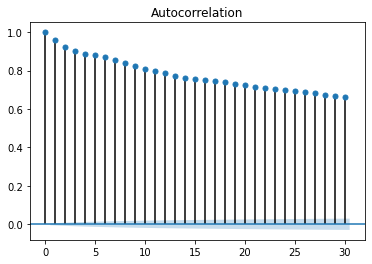

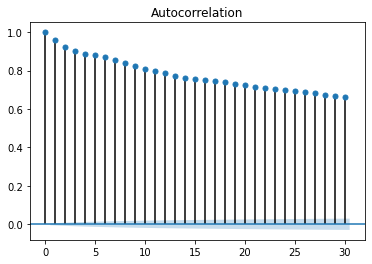

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df['Global_active_power'], lags=30)

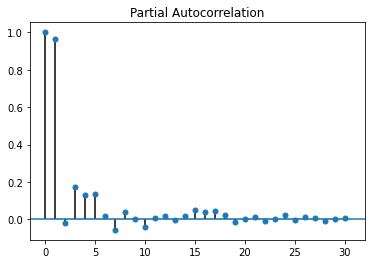

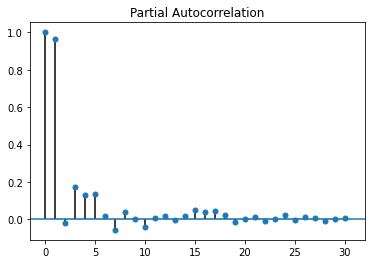

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df['Global_active_power'], lags=30)

### Statistical Normality Test

There are several statistical tests that we can use to quantify whether our data looks as though it was drawn from a Gaussian distribution. And we will use D’Agostino’s K^2 Test.

In the SciPy implementation of the test, we will interpret the p value as follows.

* p <= alpha: reject H0, not normal.
* p > alpha: fail to reject H0, normal.

We can also calculate kurtosis and skewness, to determine if the data distribution departs from the normal distribution.

In [ ]:
from scipy import stats
stat, p = stats.normaltest(df.Global_active_power)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Data looks Gaussian (fail to reject H0)')
else:
    print('Data does not look Gaussian (reject H0)')

Statistics=35296.809, p=0.000
Data does not look Gaussian (reject H0)


We can also calculate kurtosis and skewness, to determine if the data distribution departs from the normal distribution.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Kurtosis of normal distribution: 1.898647983321938
Skewness of normal distribution: 1.308126921099254


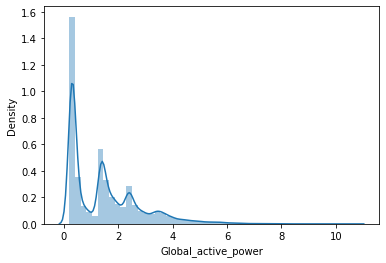

In [ ]:
# print(df.Global_active_power.describe())
sns.distplot(df.Global_active_power);
print( 'Kurtosis of normal distribution: {}'.format(stats.kurtosis(df.Global_active_power)))
print( 'Skewness of normal distribution: {}'.format(stats.skew(df.Global_active_power)))

KURTOSIS: describes heaviness of the tails of a distribution

Normal Distribution has a kurtosis of close to 0.  If the kurtosis is greater than zero, then distribution has heavier tails. If the kurtosis is less than zero, then the distribution is light tails. And our Kurtosis is greater than zero. 

SKEWNESS:

If the skewness is between -0.5 and 0.5, the data are fairly symmetrical. If the skewness is between -1 and – 0.5 or between 0.5 and 1, the data are moderately skewed. If the skewness is less than -1 or greater than 1, the data are highly skewed. And our skewness is greater than 1.

In principle we do not need to check for stationarity nor correct for it when we are using an LSTM. However, if the data is stationary, it will help with better performance and make it easier for the neural network to learn.

### Dickey-Fuller Test to Ceck Stationarity

In statistics, the Dickey–Fuller test tests the null hypothesis that a unit root is present in an autoregressive model. The alternative hypothesis is different depending on which version of the test is used, but is usually stationarity or trend-stationarity.

Stationary series has constant mean and variance over time. Rolling average and the rolling standard deviation of time series do not change over time.

### Dickey-Fuller test

Null Hypothesis (H0): It suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.

Alternate Hypothesis (H1): It suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

p-value > 0.05: Accept the null hypothesis (H0), the data has a unit root and is non-stationary.

p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [ ]:
def test_stationarity(timeseries):
    rolmean = timeseries.rolling(window=30).mean()
    rolstd = timeseries.rolling(window=30).std()
    
    plt.figure(figsize=(14,5))
    sns.despine(left=True)
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')

    plt.legend(loc='best'); plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    print ('<Results of Dickey-Fuller Test>')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

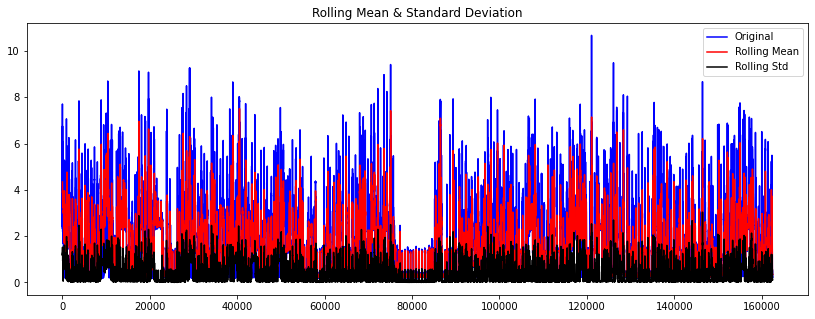

<Results of Dickey-Fuller Test>
Test Statistic                    -19.739559
p-value                             0.000000
#Lags Used                         77.000000
Number of Observations Used    162408.000000
Critical Value (1%)                -3.430390
Critical Value (5%)                -2.861558
Critical Value (10%)               -2.566779
dtype: float64


In [ ]:
test_stationarity(df.Global_active_power.dropna())

ARIMA Model

In [ ]:
#arima model
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(df['Global_active_power'], order=(2,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
    

                               ARIMA Model Results                               
Dep. Variable:     D.Global_active_power   No. Observations:               162485
Model:                    ARIMA(2, 1, 0)   Log Likelihood              -63915.060
Method:                          css-mle   S.D. of innovations              0.359
Date:                   Thu, 14 Jul 2022   AIC                         127838.121
Time:                           12:22:43   BIC                         127878.114
Sample:                                1   HQIC                        127849.999
                                                                                 
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                       -2.565e-05      0.001     -0.034      0.973      -0.001       0.001
ar.L1.D.Global_active_power    -0.0023      0.002     -0

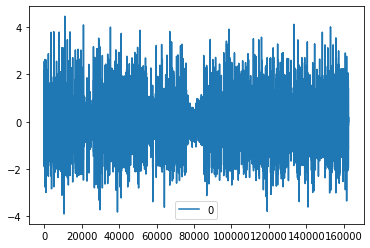

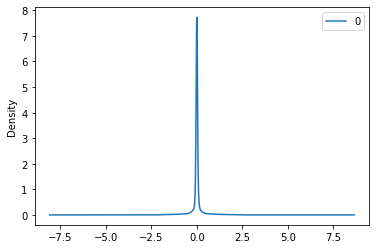

                   0
count  162485.000000
mean        0.000001
std         0.358590
min        -3.899854
25%        -0.017290
50%        -0.000484
75%         0.014595
max         4.463437


In [ ]:
#Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show(block=False)
residuals.plot(kind='kde')
plt.show(block=False)
print(residuals.describe())
    

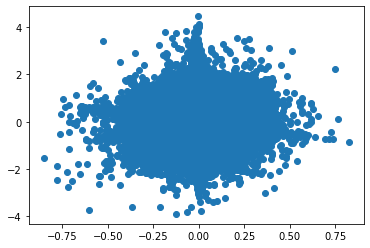

In [ ]:
#residuals vs fitted values
plt.scatter(model_fit.fittedvalues, residuals)
plt.show(block=False)
        

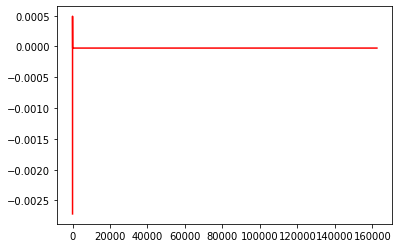

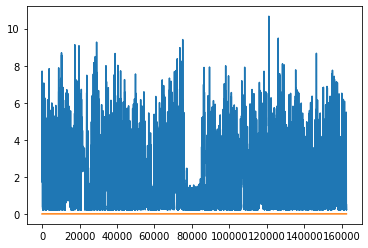

In [ ]:
#model prediction
predictions = model_fit.predict(dynamic=True)
predictions.plot(color='red')
plt.show(block=False)   #Plot the actual values and the predictions
plt.plot(df['Global_active_power'])
plt.plot(predictions)
plt.show(block=False)

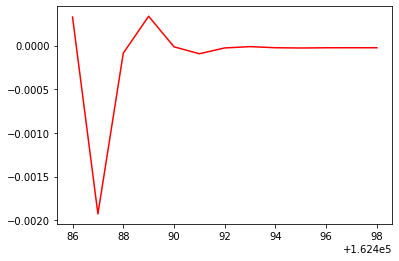

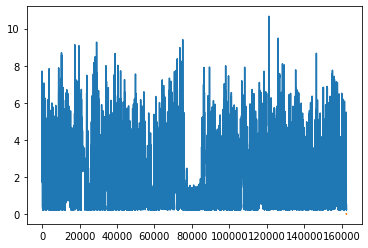

In [ ]:
#Forecasting
#Forecast for the next 12 months
predictions = model_fit.predict(start=len(df['Global_active_power']), end=len(df['Global_active_power'])+12, dynamic=True)
predictions.plot(color='red')
plt.show(block=False)
plt.plot(df['Global_active_power'])
plt.plot(predictions)
plt.show(block=False)

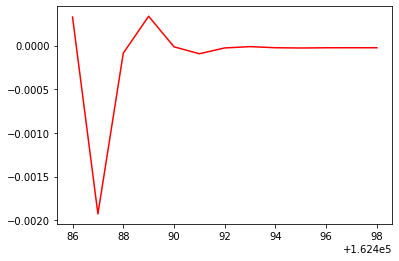

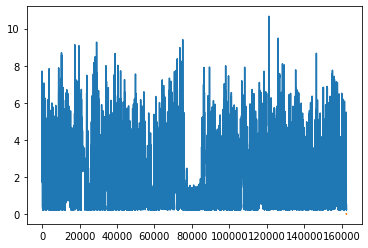

In [ ]:
y_pred = model_fit.predict(start=len(df['Global_active_power']), end=len(df['Global_active_power'])+12, dynamic=True)
y_pred.plot(color='red')
plt.show(block=False)
plt.plot(df['Global_active_power'])
plt.plot(y_pred)
plt.show(block=False)

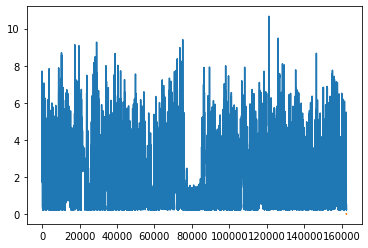

In [ ]:
#Plot the forecasted values
plt.plot(df['Global_active_power']) 
plt.plot(y_pred)
plt.show(block=False)
